In [175]:
#데이터 로드
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

file_path = "./diabetes.csv"
data = pd.read_csv(file_path)

In [177]:
#결측치 확인
missing_values = data.isnull().sum()
print(missing_values)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [179]:
X = data.drop("Outcome", axis=1) 
y = data["Outcome"]

In [181]:
#원핫 인코딩
X_encoded = pd.get_dummies(X, drop_first=True)

In [183]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

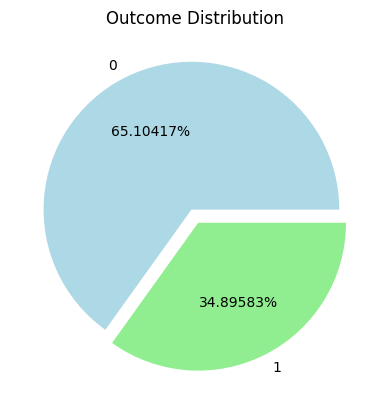

In [185]:
data.Outcome.value_counts().plot(
    kind='pie',
    autopct='%0.05f%%',
    colors=['lightblue', 'lightgreen', 'orange', 'pink'],
    explode=(0.05, 0.05)
)
plt.title("Outcome Distribution")
plt.ylabel("")  # y축 라벨 없애기
plt.show()

In [187]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [189]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

In [191]:
from sklearn.model_selection import train_test_split
import seaborn as sns

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [193]:
#학습용 데이터와 테스트용 데이터의 수를 나타내기위함
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [195]:
#딥러닝
X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.int64)
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.int64)

In [197]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [199]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [201]:
#Pytorch model 정의

class DiabetesOutcome(nn.Module):
    def __init__(self):
        super(DiabetesOutcome, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)  # 4 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesOutcome()

In [203]:
#손실 함수 최적화 기법

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [205]:
#모델 학습

train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 1.2861, Accuracy: 72.08%
Epoch 2/20, Loss: 0.9737, Accuracy: 72.08%
Epoch 3/20, Loss: 0.7202, Accuracy: 77.92%
Epoch 4/20, Loss: 0.5830, Accuracy: 79.22%
Epoch 5/20, Loss: 0.5300, Accuracy: 80.52%
Epoch 6/20, Loss: 0.5031, Accuracy: 80.52%
Epoch 7/20, Loss: 0.4973, Accuracy: 80.52%
Epoch 8/20, Loss: 0.4814, Accuracy: 81.17%
Epoch 9/20, Loss: 0.4742, Accuracy: 81.17%
Epoch 10/20, Loss: 0.4590, Accuracy: 79.87%
Epoch 11/20, Loss: 0.4592, Accuracy: 82.47%
Epoch 12/20, Loss: 0.4607, Accuracy: 80.52%
Epoch 13/20, Loss: 0.4595, Accuracy: 81.17%
Epoch 14/20, Loss: 0.4550, Accuracy: 80.52%
Epoch 15/20, Loss: 0.4484, Accuracy: 79.87%
Epoch 16/20, Loss: 0.4437, Accuracy: 81.17%
Epoch 17/20, Loss: 0.4438, Accuracy: 80.52%
Epoch 18/20, Loss: 0.4309, Accuracy: 80.52%
Epoch 19/20, Loss: 0.4390, Accuracy: 80.52%
Epoch 20/20, Loss: 0.4401, Accuracy: 80.52%
Training complete.


In [206]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[93 14]
 [16 31]]
F1 Score: 0.80
Precision: 0.80
Recall: 0.81
Specificity: 0.76


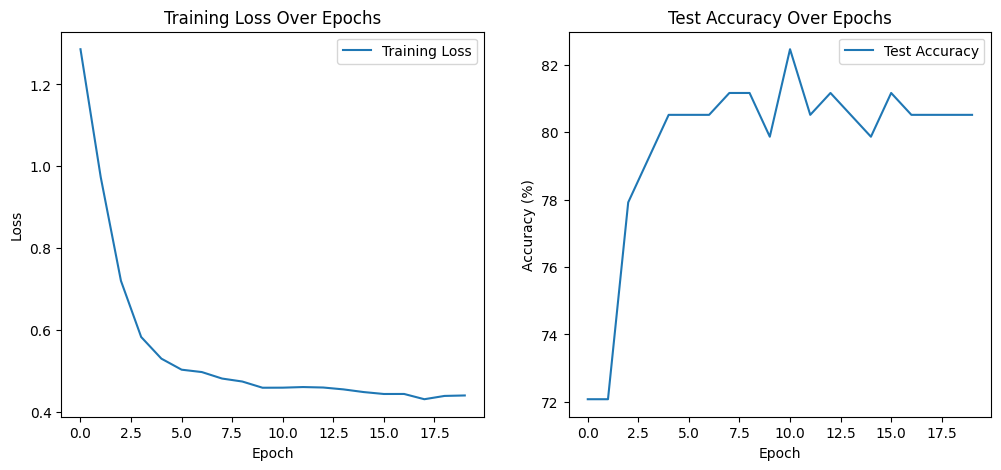

In [209]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

In [211]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [213]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [215]:
data_array = np.hstack((X, y.reshape(-1, 1)))

In [217]:
data_array.shape

(768, 9)

In [241]:
# Split sequences function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Apply sequence transformation
n_steps = 5
X, y = split_sequences(data_array, n_steps)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [243]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((611, 5, 8), (611,), (153, 5, 8), (153,))

In [245]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [247]:
# Define the 1D CNN model
class DiabetesOutcomeCNN(nn.Module):
    def __init__(self):
        super(DiabetesOutcomeCNN, self).__init__()
        self.conv1 = nn.Conv1d(8, 16, kernel_size=3, padding=1)  # Change input channels to 6
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 5, 64)  # Adjust the linear layer input size accordingly
        self.fc2 = nn.Linear(64, 4)  # 4 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [249]:
model = DiabetesOutcomeCNN()

In [251]:
from torchsummary import summary
summary(model, input_size=(8, 5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             400
            Conv1d-2                [-1, 32, 5]           1,568
            Linear-3                   [-1, 64]          10,304
            Linear-4                    [-1, 4]             260
Total params: 12,532
Trainable params: 12,532
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [253]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

Epoch 1/20, Loss: 1.1969, Accuracy: 62.75%
Epoch 2/20, Loss: 0.7161, Accuracy: 62.75%
Epoch 3/20, Loss: 0.6504, Accuracy: 62.75%
Epoch 4/20, Loss: 0.5937, Accuracy: 64.05%
Epoch 5/20, Loss: 0.5596, Accuracy: 71.24%
Epoch 6/20, Loss: 0.5050, Accuracy: 73.86%
Epoch 7/20, Loss: 0.4883, Accuracy: 73.86%
Epoch 8/20, Loss: 0.4453, Accuracy: 73.20%
Epoch 9/20, Loss: 0.4198, Accuracy: 72.55%
Epoch 10/20, Loss: 0.4034, Accuracy: 71.90%
Epoch 11/20, Loss: 0.3847, Accuracy: 73.86%
Epoch 12/20, Loss: 0.4123, Accuracy: 72.55%
Epoch 13/20, Loss: 0.3928, Accuracy: 72.55%
Epoch 14/20, Loss: 0.3702, Accuracy: 70.59%
Epoch 15/20, Loss: 0.3642, Accuracy: 72.55%
Epoch 16/20, Loss: 0.3445, Accuracy: 73.86%
Epoch 17/20, Loss: 0.3509, Accuracy: 71.24%
Epoch 18/20, Loss: 0.3258, Accuracy: 73.20%
Epoch 19/20, Loss: 0.3297, Accuracy: 72.55%
Epoch 20/20, Loss: 0.3188, Accuracy: 71.90%
Training complete.
Confusion Matrix:
[[71 25]
 [18 39]]
F1 Score: 0.72
Precision: 0.73
Recall: 0.72
Specificity: 0.71


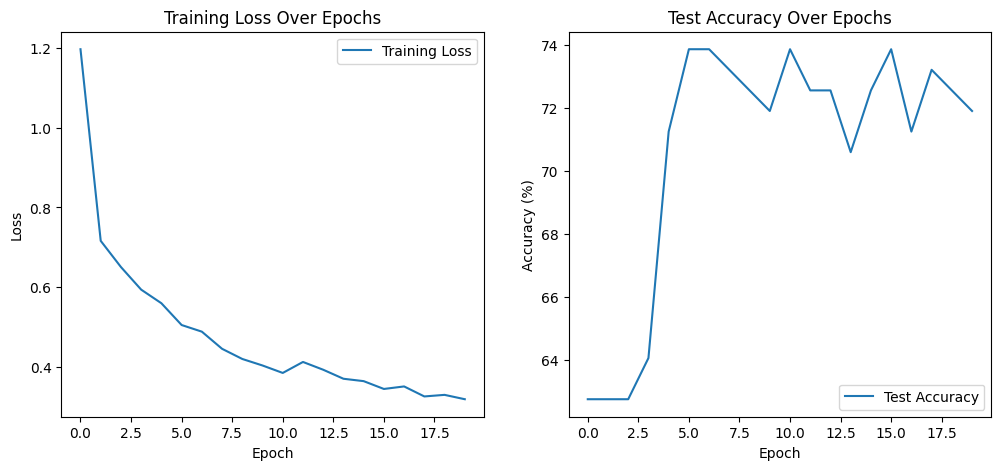

In [255]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        inputs = inputs.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# Print metrics
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()